# PyTorch. Рекуррентные нейронные сети

## 1. Подготовка данных

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Сгенерируем данные.

In [2]:
data_count = 500
noise_level = 0.1

sequence_length = 100
batch_size = int(data_count/sequence_length)
layers_count = 1
hidden_layers_count = 4

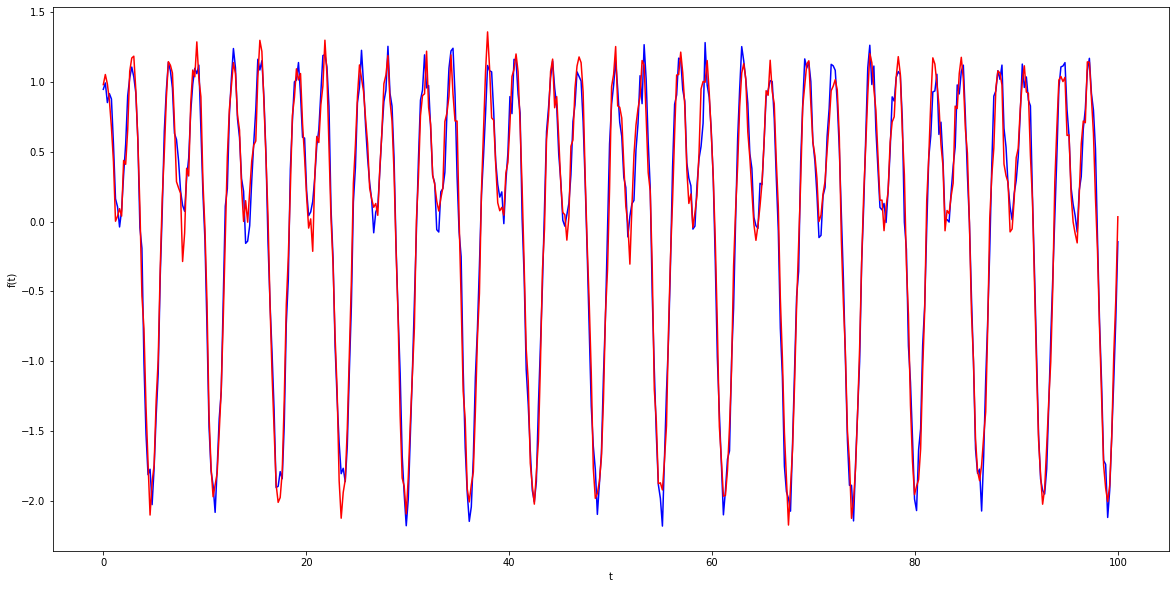

In [3]:
def generate_data(t):
    return torch.sin(t) + torch.cos(2 * t) + noise_level * torch.randn_like(t)

time_list = torch.linspace(0, 100, data_count)
train = generate_data(time_list)
test = generate_data(time_list)

plt.figure(figsize=(20, 10))
plt.xlabel('t')
plt.ylabel('f(t)')
plt.plot(time_list, train, c='blue')
plt.plot(time_list, test, c='red')

Создадим Dataset для сгенерированных данных.

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length - 1

    def __getitem__(self, index):
        data_sequence = self.data[index:index + self.sequence_length]
        next_value = self.data[index + self.sequence_length + 1]
        return data_sequence, next_value

Создадим Dataset и DataLoader для обучающей и тестовой выборок.

In [7]:
train_dataset = MyDataset(train, sequence_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = MyDataset(test, sequence_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## 2. Обучение нейронных сетей

Создадим 2 нейросети. Первая нейросеть будет использовать RNN, а вторая – LSTM.

In [6]:
from torch import nn, optim

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN,self).__init__()
        self.RNN = nn.RNN(input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity='tanh',
            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x, hState):
        x, h = self.RNN(x, hState)
        y_pred = self.linear(x[:,-1,:])
        return y_pred


In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size,num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, 1)
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size,
        self.hidden_dim),
        torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input)
        y_pred = self.linear(lstm_out[:,-1,:])
        return y_pred


In [11]:
def create_rnn():
    return RNN(1, hidden_layers_count, layers_count)

In [12]:
def create_lstm():
    return LSTM(1, hidden_layers_count, batch_size=batch_size, num_layers=layers_count)

Создадим методы для обучения нейросетей.

In [13]:
loss_fn = nn.MSELoss(reduction='sum')

In [28]:
def train_rnn(dataloader, n_epochs, learning_rate):
    neural_network = create_rnn()

    optimizer = torch.optim.Adam(neural_network.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        current_mse = 0
        for data_sequence, next_value in dataloader:
            hidden_state = torch.zeros([layers_count, batch_size, hidden_layers_count])
            neural_network.train()

            prediction = neural_network(data_sequence.reshape([batch_size, sequence_length, 1]), hidden_state)
            loss = loss_fn(next_value, prediction.view(-1))
            current_mse += loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        current_mse = current_mse / batch_size


        if (epoch % 20) == 0:
            print(f'epoch: {epoch}, loss: {current_mse:.5f}')
    
    return neural_network

In [29]:
def train_lstm(dataloader, n_epochs, learning_rate):
    neural_network = create_lstm()

    optimizer = torch.optim.Adam(neural_network.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        current_mse = 0
        for data_sequence, next_value in dataloader:
            neural_network.hidden = neural_network.init_hidden()
            neural_network.train()
            
            prediction = neural_network(data_sequence.reshape([batch_size, sequence_length, 1]))
            loss = loss_fn(next_value, prediction.view(-1))
            current_mse += loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        current_mse = current_mse / batch_size


        if (epoch % 20) == 0:
            print(f'epoch: {epoch}, loss: {current_mse:.5f}')
    
    return neural_network

Обучим нейросети.

Нейросеть, использующая LSTM, имеет гораздо меньшие значения ошибок, но при этом гораздо дольше обучается.

In [17]:
trained_rnn = train_rnn(train_dataloader, 500, 0.02)
trained_rnn

epoch: 0, loss: 22.90153
epoch: 20, loss: 6.28518
epoch: 40, loss: 4.07465
epoch: 60, loss: 4.04628
epoch: 80, loss: 3.68569
epoch: 100, loss: 3.31965
epoch: 120, loss: 3.04844
epoch: 140, loss: 3.83313
epoch: 160, loss: 3.71133
epoch: 180, loss: 3.31955
epoch: 200, loss: 3.26219
epoch: 220, loss: 3.33320
epoch: 240, loss: 3.71212
epoch: 260, loss: 3.41201
epoch: 280, loss: 3.33294
epoch: 300, loss: 3.54369
epoch: 320, loss: 3.47774
epoch: 340, loss: 3.20249
epoch: 360, loss: 3.29749
epoch: 380, loss: 3.22723
epoch: 400, loss: 4.04712
epoch: 420, loss: 3.20783
epoch: 440, loss: 3.02011
epoch: 460, loss: 3.62447
epoch: 480, loss: 3.30428


RNN(
  (RNN): RNN(1, 4, batch_first=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
trained_lstm = train_lstm(train_dataloader, 500, 0.02)
trained_lstm

epoch: 0, loss: 30.99370
epoch: 20, loss: 2.99212
epoch: 40, loss: 1.93856
epoch: 60, loss: 1.53048
epoch: 80, loss: 1.58203
epoch: 100, loss: 1.58760
epoch: 120, loss: 1.49627
epoch: 140, loss: 1.23667
epoch: 160, loss: 1.49043
epoch: 180, loss: 1.25060
epoch: 200, loss: 1.45454
epoch: 220, loss: 1.34377
epoch: 240, loss: 1.37024
epoch: 260, loss: 1.33021
epoch: 280, loss: 1.38755
epoch: 300, loss: 1.31127
epoch: 320, loss: 1.31000
epoch: 340, loss: 1.75846
epoch: 360, loss: 1.07285
epoch: 380, loss: 1.20688
epoch: 400, loss: 1.14538
epoch: 420, loss: 1.31472
epoch: 440, loss: 1.25952
epoch: 460, loss: 1.09677
epoch: 480, loss: 1.12276


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

## 3. Визуализация результатов

Получим прогнозы нейросетей на тестовой выборке и визуализируем их.

Видно, что нейросеть, использующая LSTM, дает заметно более точные прогнозы, чем нейросеть, использующая RNN.

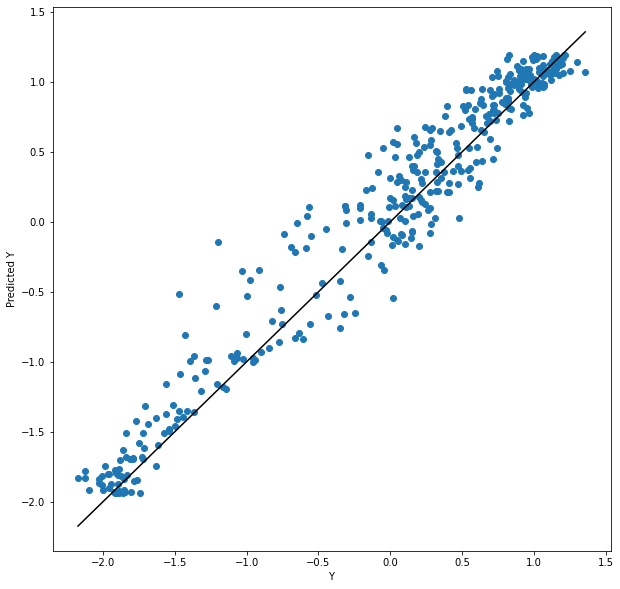

In [31]:
data = None
prediction = None

trained_rnn.eval()

for x_data, y_data in test_dataloader:
    hidden_state = torch.zeros([layers_count, batch_size, hidden_layers_count])
    y_pred = trained_rnn(x_data.reshape([batch_size, sequence_length, 1]), hidden_state)

    y_data = y_data.detach().numpy()
    y_pred = y_pred.detach().numpy()
    
    if data is None:
        data = y_data
        prediction = y_pred
    else:
        data = np.concatenate([data, y_data])
        prediction = np.concatenate([prediction, y_pred])

all_values = np.concatenate([data, prediction.squeeze()])
min_value = all_values.min()
max_value = all_values.max()

plt.figure(figsize=(10, 10))
plt.xlabel("Y")
plt.ylabel("Predicted Y")
plt.plot([min_value, max_value], [min_value, max_value], c='black')
plt.scatter(data, prediction)

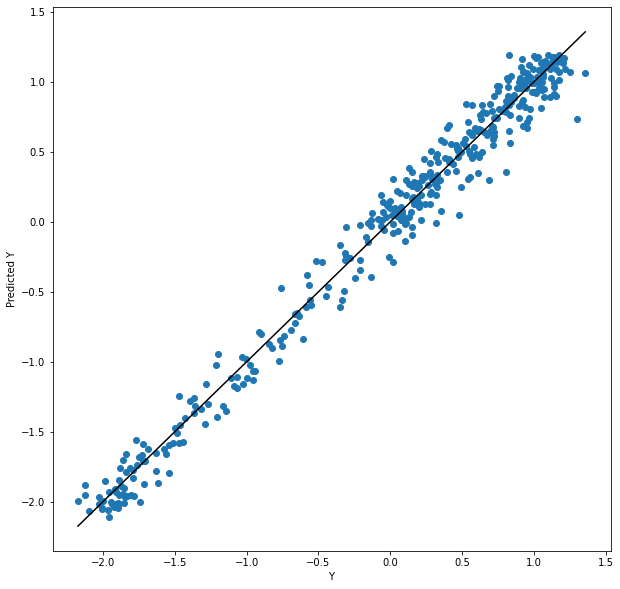

In [32]:
data = None
prediction = None

trained_lstm.eval()
for x_data, y_data in test_dataloader:
    trained_lstm.hidden = trained_lstm.init_hidden()
    y_pred = trained_lstm(x_data.reshape([batch_size, sequence_length, 1]))

    y_data = y_data.detach().numpy()
    y_pred = y_pred.detach().numpy()

    if data is None:
        data = y_data
        prediction = y_pred
    else:
        data = np.concatenate([data, y_data])
        prediction = np.concatenate([prediction, y_pred])

all_values = np.concatenate([data, prediction.squeeze()])
min_value = all_values.min()
max_value = all_values.max()

plt.figure(figsize=(10, 10))
plt.xlabel("Y")
plt.ylabel("Predicted Y")
plt.plot([min_value, max_value], [min_value, max_value], c='black')
plt.scatter(data, prediction)